# Zajęcia 3 - bagging, lasy losowe, ExtraTrees

## Importy

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
from sklearn.datasets import fetch_openml  # for downloading remote datasets\
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from time import time
import pandas as pd
from random import randint

In [2]:
# a little workaround to suppress nonessential warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Ładowanie danych

Zgodnie z obietnicą sprawdzimy, dlaczego lasy lepiej przewidują rozwody od drzew. Wykorzystamy zatem zbiór danych Divorce Predictors Dataset, znany z ostatniego notebooka. Załadujmy więc plik .csv za pomocą biblioteki Pandas, podzielmy go na cechy i klasy, a potem na zbiór treningowy i testowy.

In [3]:
div_X = pd.read_csv("divorce_dataset.csv", sep=";")  # Divorce dataset uses non-standard ";" instead of "," in .csv

# remove classes from X
div_y = div_X.pop("Class")

# notice that Scikit-learn method can take Pandas data structures directly
div_X_train, div_X_test, div_y_train, div_y_test = train_test_split(div_X, div_y, test_size=.25, random_state=0)

Wykorzystamy także zbiór **MNIST** - jest to zbiór 70 tysięcy ręcznie pisanych cyfr, jeden z najbardziej znanych zbiorów w machine learningu. Dzięki dość dużemu rozmiarowi i niewielkim obrazkom (28x28 pikseli) stanowi dobry materiał do trenowania i porównywania różnych algorytmów.  
Uwaga - normalnym jest, że to się chwilę ściąga, jest to względnie dużo danych.

In [4]:
mnist_X, mnist_y = fetch_openml('mnist_784', return_X_y=True)

In [5]:
# change number of rows used below if calculations using MNIST are taking too long
mnist_X = mnist_X[:10000, :]
mnist_y = mnist_y[:10000]

mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(mnist_X, mnist_y, test_size=.25, random_state=0)

Obrazy to macierze 2D, my chcemy przykłady uczące 1D, więc w powyższym zbiorze są one **spłaszczone** (flattened) do postaci 1D. Chcąc narysować przykładową cyfrę, musimy użyć funkcji Numpy'a `reshape`, która w szczególności przydaje się do transformacji wektorów 1D <-> 2D.

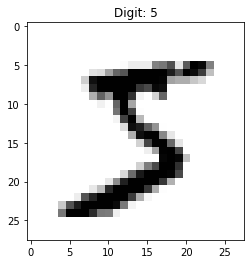

In [11]:
plt.imshow(mnist_X[0].reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Digit: {}".format(mnist_y[0]))
plt.show()

Na koniec dorzucimy jeszcze zbiór Adult Data Set (zwany także Census Income Dataset), będący zbiorem danych o dochodach obywateli USA z 1994 roku. Jest to zbiór do klasyfikacji binarnej - czy dana osoba zarabia co najmniej 50 tys. dolarów rocznie, czy nie.  
Problem podziału konsumentów na różne progi zarobków pojawia się bardzo często np. w tematyce spersonalizowanych reklam.  
Opis zbioru: https://archive.ics.uci.edu/ml/datasets/Adult

In [12]:
df = pd.read_csv("adult_dataset.data", header=None)

print(df.head())

   0                  1       2           3   4                    5   \
0  39          State-gov   77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12  \
0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  
3   United-State

Niektóre wiersze zawierają wartości brakujące - usuniemy je w tym wypadku.

In [13]:
df.dropna(axis="index", inplace=True)

Zanim dokonamy klasyfikacji, wykorzystamy **Label Encoder** do zamiany zmiennych kategorycznych (w tym klas) w postaci stringów na liczby. Dzięki temu klasyfikatory oczekujące wejścia numerycznego dostaną wejście numeryczne, ale działające jak zmienna kategoryczna.

In [14]:
le = LabelEncoder()
for column_name in df.columns:
    if df[column_name].dtype == object:
        df[column_name] = le.fit_transform(df[column_name])
        
print(df.head())

   0   1       2   3   4   5   6   7   8   9     10  11  12  13  14
0  39   7   77516   9  13   4   1   1   4   1  2174   0  40  39   0
1  50   6   83311   9  13   2   4   0   4   1     0   0  13  39   0
2  38   4  215646  11   9   0   6   1   4   1     0   0  40  39   0
3  53   4  234721   1   7   2   6   0   2   1     0   0  40  39   0
4  28   4  338409   9  13   2  10   5   2   0     0   0  40   5   0


Niektóre wiersze zawierają wartości brakujące - usuniemy je w tym wypadku.

Teraz możemy już dokonać podziału zbioru na zbiory treningowy i testowy.

In [15]:
adult_y = df[14].values
adult_X = df.drop(14, axis=1)

adult_X_train, adult_X_test, adult_y_train, adult_y_test = train_test_split(adult_X, adult_y, test_size=.25, random_state=0)

## Bagging

Bagging, jak pamiętamy z wykładu, trenuje serię niezależnych klasyfikatorów z pomocą bootstrappingu, który jest po prostu losowaniem ze zwracaniem.

### Zadanie 1

Napisz funkcję `get_bootstrap_sample`, która dla danych `X` (macierz przykładów treningowych) i `y` (wektor klas) zwróci próbkę bootstrapową zadanego rozmiaru `size`. Zwróć uwagę na to, że trzeba zwrócić zarówno wybrane wiersze (być może z powtórzeniami) z `X`, jak i odpowiadające im klasy z `y` (pod tymi samymi indeksami).  
Jako dodatkowe wyzwanie, postaraj się maksymalnie użyć Numpy'a - jego metody i możliwość wykorzystania **wektoryzacji** (uogólnienia funkcji, żeby działały na całych macierzach/wierszach/kolumanch) oraz indeksowania za pomocą **masek** (np. `[0, 1, 1, 0]` oznacza "wybierz drugi i trzeci element z 4-elementowego wektora") są bardzo wydajne i nieodzowne w przypadku dużych ilości danych.

In [17]:
def get_bootstrap_sample(X, y, size=1):
    n = len(X)
    X_sample, y_sample = [], []
    for _ in range(size):
        ind_rand = randint(0, n-1)
        X_sample.append(X[ind_rand])
        y_sample.append(y[ind_rand])
        
    return X_sample, y_sample

## Bagging jako przykład algorytmu embarassingly parallel

Bagging jest operacją, którą określamy mianem embarassingly parallel, dlaczego by więc nie wykorzystać wielu rdzeni naszego procesora, a nawet wszystkich dostępnych? Scikit-learn udostępnia taką opcję w postaci argumentu `n_jobs`, który domyślnie ma wartość 1, a dla wartości -1 wykorzystuje tyle rdzeni, ile tylko jest dostępne.  
Porównamy czasy treningu i predykcji działania dla różnej liczby rdzeni dla zbioru MNIST dla baggingu z domyślnymi parametrami (używa drzew decyzyjnych), wykorzystując poniższe funkcje pomocnicze.
Jeżeli znasz **prawo Amdahla**, to jest ono tutaj wyjątkowo łaskawe, bo dla problemów embarassingly parallel daje się osiągnąć (przynajmniej w teorii) liniowy zysk czasowy wraz ze wzrostem liczby procesorów.  

Uwaga: poniższy kod będzie wykonywał się dość długo, jest to normalne, bo wykonujemy go bardzo dużo razy, żeby narysować wykres. Dodałem printy, żeby nie mieć poczucia, że kod się "zawiesił".

In [18]:
cores = os.cpu_count()  # get the number of cores


def evaluate_cores(model, X, y):
    # we'll check for those sizes
    N = [1000, 2000, 3000, 4000, 5000]

    model_dict = {f"model_{n}": model(n_jobs=n) for n in range(1, cores + 1)}  # contruct model:instance pairs
    data_dict = {model: [] for model in model_dict.keys()}  # prepare data for storage

    for n in N:
        print("n:", n)
        for k in data_dict.keys():
            start = time()
            model_dict[k].fit(X, y)
            end = time()
            elapsed = end - start
            data_dict[k].append(elapsed)  # add time to dict
            print("\t - fit time:", elapsed)

    data_dict["N"] = N
    df = pd.DataFrame.from_dict(data_dict)
    return df


def visualize(df):
    ys = df.copy()  # get y-values
    xs = ys.pop('N')  # get x-values

    plt.plot(xs, ys)
    plt.title("Average Model Training Time")
    plt.xlabel("Sample Size ($n$)")
    plt.ylabel("Time")
    plt.legend([f"n_jobs={n}" for n in range(1, cores + 1)])
    
    plt.show()

n: 1000
	 - fit time: 7.934725999832153
	 - fit time: 5.124551773071289
	 - fit time: 4.692403078079224
	 - fit time: 3.3734891414642334
	 - fit time: 3.5575714111328125
	 - fit time: 2.6879658699035645
	 - fit time: 2.6607232093811035
	 - fit time: 2.6140058040618896
n: 2000
	 - fit time: 7.937718391418457
	 - fit time: 5.5624306201934814
	 - fit time: 4.8086628913879395
	 - fit time: 3.3078842163085938
	 - fit time: 3.6004278659820557
	 - fit time: 2.739619731903076
	 - fit time: 2.70196795463562
	 - fit time: 2.5023233890533447
n: 3000
	 - fit time: 7.77163553237915
	 - fit time: 5.451172828674316
	 - fit time: 4.422916889190674
	 - fit time: 3.3544068336486816
	 - fit time: 3.4248664379119873
	 - fit time: 2.6395227909088135
	 - fit time: 2.53979229927063
	 - fit time: 2.6383564472198486
n: 4000
	 - fit time: 7.842890501022339
	 - fit time: 5.62174391746521
	 - fit time: 4.450798749923706
	 - fit time: 3.256105661392212
	 - fit time: 3.7626748085021973
	 - fit time: 2.6960091590881

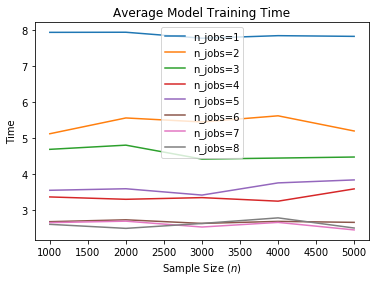

In [19]:
model = BaggingClassifier # what will go there? Something with BaggingClassifier class? Remember - in Python *everything* is an object
df = evaluate_cores(model, mnist_X_train, mnist_y_train)
visualize(df)

Z wykresu powinno jasno wynikać przy właściwie każdym wykonaniu, że większa liczba rdzeni = lepiej i szybciej, z ewentualnymi drobnymi lokalnymi wahaniami.

### Zadanie 2

Przewagą baggingu nad lasami losowymi jest to, że może używać dowolnych klasyfikatorów, nie tylko drzew decyzyjnych. Wypróbuj bagging dla 32 klasyfikatorów bazowych dla zbioru Divorce dataset oparty o:
- kNN dla k=1,
- kNN dla k=sqrt(n),
- pieńki decyzyjne (drzewa decyzyjne o max_depth=1)
- drzewa decyzyjne o dowolnej głębokości
- SVMy (nie mówiliśmy jeszcze o tym klasyfikatorze, ale jest to klasyfikator low bias, high variance)

Porównaj accuracy, używając `oob_score`, która oblicza jego out-of-bag estimate. Które z użytych klasyfikatorów są stabilne, a które nie? Które mają niski/wysoki bias/variance? Którego rodzaju klasyfikatory nadają się najlepiej do tego rodzaju ensemblingu?

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from math import sqrt

def get_accuracy(base_classifier, X, y):
    # write other appropriate options - those provided are mostly for utility
    bagging_classifier = BaggingClassifier(base_estimator = base_classifier, n_estimators=32, n_jobs=-1, random_state=0, oob_score=True)
    bagging_classifier.fit(X, y)
    return bagging_classifier.oob_score_
      
X, y = div_X_train, div_y_train
classifiers = {"Knn1": KNeighborsClassifier(n_neighbors=1),
"KnnSqrt": KNeighborsClassifier(n_neighbors=int(sqrt(len(X)))),
"Trunk": DecisionTreeClassifier(max_depth=1),
"FullTree": DecisionTreeClassifier(),
"svm":SVC()}
for name, classifier in classifiers.items():
    print(f'{name}: ', get_accuracy(classifier, X, y))


Knn1:  0.984251968503937
KnnSqrt:  0.984251968503937
Trunk:  0.9763779527559056
FullTree:  0.984251968503937
svm:  0.984251968503937


## Lasy losowe

Lasy losowe stanowią ulepszenie baggingu o losowanie pewnej liczby cech `max_features` przy każdym splicie, co dekoreluje drzewa i przyspiesza klasyfikację względem baggingu. Zobaczmy, czy faktycznie tak jest, na przykładzie Divorce dataset - kto w końcu powiedział, że wszystkie lasy równie dobrze znają się na rozwodach?  
Dla miarodajnego pomiaru używamy baggingu opartego o drzewa decyzyjne oraz trochę większej liczby klasyfikatorów bazowych niż domyślne 10 - to zbyt mało, żeby OOB było miarodajne. Porównujemy także klasyfikatory na jednolitym zbiorze testowym - pamiętaj zawsze o tym, że wyniki walidacji skrośnej czy OOB to tylko estymacje błędu generalizacji na zbiorach walidacyjnych, klasyfikatory pomiędzy sobą zawsze porównujemy na zbiorze testowym. Pomaga to też wykryć overfitting.

In [26]:
bagging_classifier = BaggingClassifier(n_estimators=32, n_jobs=-1, oob_score=True, random_state=0)
random_forest = RandomForestClassifier(n_estimators=32, n_jobs=-1, oob_score=True, random_state=0)

bagging_classifier.fit(div_X_train, div_y_train)
random_forest.fit(div_X_train, div_y_train)

print("Bagging classifier OOB accuracy:", bagging_classifier.oob_score_)
print("Random forest OOB accuracy:", random_forest.oob_score_)

print()

print("Bagging classifier test accuracy:", bagging_classifier.score(div_X_test, div_y_test))
print("Random forest test accuracy:", random_forest.score(div_X_test, div_y_test))

Bagging classifier OOB accuracy: 0.984251968503937
Random forest OOB accuracy: 0.984251968503937

Bagging classifier test accuracy: 0.9534883720930233
Random forest test accuracy: 0.9534883720930233


Jak widać, dla tak prostego zbioru jak Divorce dataset oba klasyfikatory wykazały taką samą dokładność. Co jednak z trudniejszym zbiorem, takim jak MNIST?

In [27]:
bagging_classifier = BaggingClassifier(n_estimators=32, n_jobs=-1, oob_score=True, random_state=0)
random_forest = RandomForestClassifier(n_estimators=32, n_jobs=-1, oob_score=True, random_state=0)

bagging_classifier.fit(mnist_X_train, mnist_y_train)
random_forest.fit(mnist_X_train, mnist_y_train)

print("Bagging classifier OOB accuracy:", bagging_classifier.oob_score_)
print("Random forest OOB accuracy:", random_forest.oob_score_)

print()

print("Bagging classifier test accuracy:", bagging_classifier.score(mnist_X_test, mnist_y_test))
print("Random forest test accuracy:", random_forest.score(mnist_X_test, mnist_y_test))

Bagging classifier OOB accuracy: 0.9013333333333333
Random forest OOB accuracy: 0.9092

Bagging classifier test accuracy: 0.916
Random forest test accuracy: 0.9328


Różnica co prawda nie jest wielka, ale jest. Im trudniejszy zbiór, tym bardziej będzie widoczna - MNIST, pomimo dużego rozmiaru i teoretycznie dość trudnego zadania, jest w praktyce dla wielu algorytmów co najwyżej przeciętnie trudny.

### Zadanie 3

Powszechnie sądzi się, że Random Forest nie overfittuje. Sprawdź, czy im więcej drzew, tym mądrzejsze będą w kwestii przewidywania zarobków mieszkańców USA. Narysuj w tym celu wykres zależności błędu OOB (nie precyzji!) od liczby drzew.  
Aby uzyskać tutaj miarodajne wyniki, trzeba tu będzie użyć opcji `warm_start`, aby dodawać kolejne drzewa do już istniejącego lasu, uniemożliwi to jednak niestety użycie wielu rdzeni do treningu wielu drzew.  
Pomocny w kwestii tego parametru link: https://stackoverflow.com/questions/42757892/how-to-use-warm-start

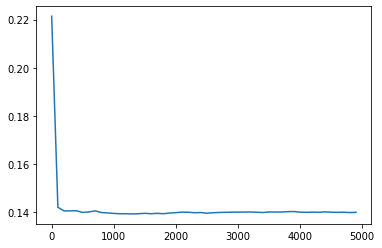

In [33]:
forest = RandomForestClassifier(n_jobs = -1, n_estimators = 1, warm_start=True, oob_score=True)     
X, y = adult_X_train, adult_y_train
scores, x_axis = [], []

for n in range(0, 5000, 100):
    if n != 0: forest.n_estimators = n
    forest.fit(X, y)
    
    scores.append(1 - forest.oob_score_)
    x_axis.append(n)
    
plt.plot(x_axis, scores)
plt.show()

## Extra Trees

Dzięki bardzo dużej dekorelacji drzew klasyfikator Extra Trees przydaje się do jednej, bardzo szczególnej rzeczy (poza oczywiście samą klasyfikacją) - sprawdzania wagi poszczególnych cech. W końcu drzewa mają "wbudowaną" taką funkcjonalność, bo na podstawie szacowania ważności cech podejmują decyzję o podziale (ważniejsze cechy lepiej dzielą klasy). Sprawdźmy więc, na co najbardziej trzeba uważać, żeby uniknąć rozwodu.

In [45]:
classifier = ExtraTreesClassifier(n_estimators=250, random_state=0)

classifier.fit(div_X_train, div_y_train)
importances = classifier.feature_importances_  # raw numbers - they don't tell us much
indices = list(np.argsort(importances)[::-1])  # if we sorted importances decreasing, at which index would be every position?
print(indices)  # uncomment, if you're interested

for i in range(0, 5):
    print(i + 1, "feature is at index", indices.index(i))  #moze chodzi o indices.index(i) + 1  ?

[17, 16, 10, 18, 39, 38, 8, 19, 4, 37, 13, 35, 3, 40, 15, 25, 9, 14, 43, 0, 27, 28, 24, 26, 2, 11, 29, 20, 31, 7, 32, 34, 1, 36, 22, 12, 21, 33, 53, 30, 6, 41, 52, 51, 48, 49, 5, 23, 47, 42, 44, 46, 45, 50]
1 feature is at index 19
2 feature is at index 32
3 feature is at index 24
4 feature is at index 12
5 feature is at index 8


Porównaj wartości cech z https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set - w końcu nie wiadomo, kiedy to może się przydać.

### Zadanie 4

Zostałeś zatrudniony/zatrudniona przez niewielki amerykański startup, który dla oszczędności otworzył biuro w Polsce. Podpisał on umowę z kilkoma firmami sprzedającymi drogie, markowe produkty, aby wykonywać dla nich analizy z zakresu data science. Twoim jest wyznaczyć, na jakich cechach powinny się skupić wysiłki firm, aby zwiększyć sprzedaż, a przy tym nie wydać zbyt wiele na reklamę. Nie wiesz, ile takich cech może być.  
Dla oszczędności chcesz wykorzystać ogólnodostępny zbiór Census Income Dataset (są też inne podobne, nowsze, ale ten znasz z zajęć na BIT AI), którego klasy zostały przepisane poniżej.  
Zaproponuj metodę, która pozwoli rozwiązać przedstawione przed tobą zadanie. Pamiętaj, że musisz także zaproponować jakiś sposób sprawdzenia, ile cech należy uwzględnić - może być to albo metoda graficzna (świetnie sprzeda się na prezentacji klientowi), albo automatyczny algorytm (który będziesz mógł/mogła wykorzystać też w innych projektach z ML).

In [52]:
labels = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

classifier = ExtraTreesClassifier(n_estimators=250, random_state=0)

classifier.fit(adult_X_train, adult_y_train)
importances = classifier.feature_importances_  # raw numbers - they don't tell us much
indices = list(np.argsort(importances)[::-1])  # if we sorted importances decreasing, at which index would be every position?
print("Most important for deciding, whom should we target, are: ")

for i in range(0, 5):
    label_ind = indices.index(i)
    print(f" Number {i + 1}: {labels[label_ind]}")

Most important for deciding, whom should we target, are: 
 Number 1: workclass
 Number 2: race
 Number 3: age
 Number 4: sex
 Number 5: marital-status
